# NBA Stats Analysis (Robust Scraping Pipeline)

**Name:** Pradhan Kolli

**Date:** 12/9/25

**Course:** Data Science Programming

## Project Overview

This project scrapes NBA statistics from **TeamRankings.com** to analyze team performance.

### Data Source
**Website:** TeamRankings (NBA stats)  
**URLs Scraped:**
1. [Win Percentage](https://www.teamrankings.com/nba/stat/win-pct-all-games)
2. [Points Per Game](https://www.teamrankings.com/nba/stat/points-per-game)
3. [Opponent Points Per Game](https://www.teamrankings.com/nba/stat/opponent-points-per-game)
4. [Three Point Percentage](https://www.teamrankings.com/nba/stat/three-point-pct)
5. [Total Rebounds Per Game](https://www.teamrankings.com/nba/stat/total-rebounds-per-game)

### Questions Explored
1. Is there a correlation between **Points Per Game** and **Win Percentage**?
2. Do teams with higher **3-Point Percentages** tend to have higher Win Percentages?
3. Do teams that grab more **Total Rebounds** allow fewer **Opponent Points**?
4. Which teams are "Glass Cannons" (Top 10 in Scoring but Bottom 10 in Defense)?
5. Do the top 10 rebounding teams generally have a winning record (> 50% Win Pct)?


In [9]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Robust Web Scraping Function

We use `requests` and `BeautifulSoup` to manually parse the HTML. This avoids the `html5lib`/`lxml` errors associated with `pd.read_html`.

In [10]:
# Define URLs for reliable stats
urls = {
    'Win_Pct': 'https://www.teamrankings.com/nba/stat/win-pct-all-games',
    'Points_Per_Game': 'https://www.teamrankings.com/nba/stat/points-per-game',
    'Opponent_Points': 'https://www.teamrankings.com/nba/stat/opponent-points-per-game',
    'Three_Point_Pct': 'https://www.teamrankings.com/nba/stat/three-point-pct',
    'Total_Rebounds': 'https://www.teamrankings.com/nba/stat/total-rebounds-per-game'
}

def scrape_nba_stats(url, stat_name):
    """
    Scrapes a TeamRankings table manually using BeautifulSoup.
    Extracts 'Team' and the current stat value (usually the 3rd column).
    """
    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.content, 'html.parser')
        
        
        table = soup.find('table', class_='tr-table datatable scrollable')
        
        if not table:
          
            table = soup.find('table')
            
        if not table:
            print(f"Error: Table not found on {url}")
            return None

        data = []
        rows = table.find_all('tr')
        
        for row in rows[1:]:
            cols = row.find_all('td')
            if len(cols) >= 3:
               
                team_text = cols[1].get_text(strip=True)
                
                stat_val = cols[2].get_text(strip=True)
                
                # Clean Team Name (remove record like "Boston (50-10)")
                if '(' in team_text:
                    team_text = team_text.split('(')[0].strip()
                
                data.append([team_text, stat_val])
        
        df = pd.DataFrame(data, columns=['Team', stat_name])
        
        # Clean numeric data immediately
        # Remove '%' symbols if present
        df[stat_name] = df[stat_name].astype(str).str.replace('%', '', regex=False)
        
        df[stat_name] = pd.to_numeric(df[stat_name], errors='coerce')
        
        print(f"Successfully scraped {len(df)} records for {stat_name}")
        return df

    except Exception as e:
        print(f"An error occurred while scraping {url}: {e}")
        return None

## 2. Merge and Clean Data

In [11]:
# Initialize
master_df = None

# Scrape
for stat, url in urls.items():
    df = scrape_nba_stats(url, stat)
    if df is not None:
        if master_df is None:
            master_df = df
        else:
            master_df = pd.merge(master_df, df, on='Team', how='outer')

# Final Cleaning check
if master_df is not None:
    master_df.dropna(inplace=True)
    master_df.reset_index(drop=True, inplace=True)
    print("\n--- Final Dataset ---")
    print(master_df.head())
    print(f"Dataset Shape: {master_df.shape}")
else:
    print("CRITICAL: Dataset creation failed.")

Successfully scraped 30 records for Win_Pct
Successfully scraped 30 records for Points_Per_Game
Successfully scraped 30 records for Opponent_Points
Successfully scraped 30 records for Three_Point_Pct
Successfully scraped 30 records for Total_Rebounds

--- Final Dataset ---
        Team  Win_Pct  Points_Per_Game  Opponent_Points  Three_Point_Pct  \
0  Okla City    0.958            123.0            106.9             37.4   
1    Detroit    0.792            118.7            113.3             35.4   
2  LA Lakers    0.739            118.3            116.1             35.8   
3     Denver    0.739            125.0            116.3             39.7   
4    Houston    0.714            120.9            110.3             39.9   

   Total_Rebounds  
0            54.2  
1            57.0  
2            50.1  
3            53.0  
4            60.2  
Dataset Shape: (30, 6)


## 3. Data Analysis & Visualization

### Q1: Is there a correlation between Points Per Game and Win Percentage?

Correlation Coefficient: 0.821


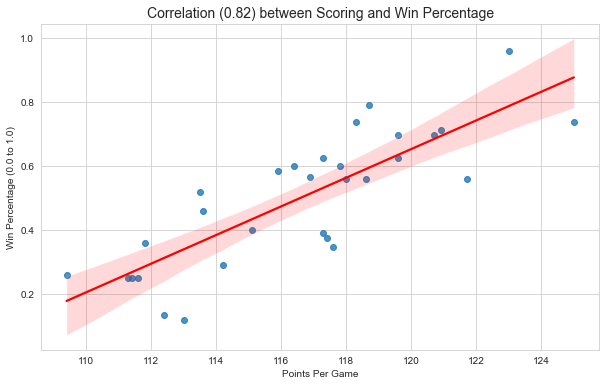

In [12]:
if 'Points_Per_Game' in master_df.columns and 'Win_Pct' in master_df.columns:
    corr = master_df['Points_Per_Game'].corr(master_df['Win_Pct'])
    print(f"Correlation Coefficient: {corr:.3f}")

    plt.figure(figsize=(10, 6))
    sns.regplot(x='Points_Per_Game', y='Win_Pct', data=master_df, line_kws={'color':'red'})
    plt.title(f'Correlation ({corr:.2f}) between Scoring and Win Percentage', fontsize=14)
    plt.ylabel('Win Percentage (0.0 to 1.0)')
    plt.xlabel('Points Per Game')
    plt.show()

### Q2: Do teams with higher 3-Point Percentages tend to have higher Win Percentages?

Correlation Coefficient: 0.455


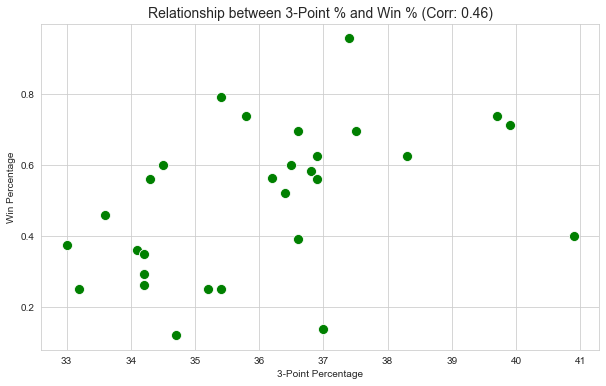

In [13]:
if 'Three_Point_Pct' in master_df.columns and 'Win_Pct' in master_df.columns:
    corr_3pt = master_df['Three_Point_Pct'].corr(master_df['Win_Pct'])
    print(f"Correlation Coefficient: {corr_3pt:.3f}")
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Three_Point_Pct', y='Win_Pct', data=master_df, s=100, color='green')
    plt.title(f'Relationship between 3-Point % and Win % (Corr: {corr_3pt:.2f})', fontsize=14)
    plt.xlabel('3-Point Percentage')
    plt.ylabel('Win Percentage')
    plt.show()

### Q3: Do teams that grab more Total Rebounds allow fewer Opponent Points?

In [14]:
if 'Total_Rebounds' in master_df.columns and 'Opponent_Points' in master_df.columns:
    # Divide into Top Half vs Bottom Half Rebounding Teams
    median_reb = master_df['Total_Rebounds'].median()
    high_reb = master_df[master_df['Total_Rebounds'] >= median_reb]['Opponent_Points'].mean()
    low_reb = master_df[master_df['Total_Rebounds'] < median_reb]['Opponent_Points'].mean()
    
    print(f"Avg Opponent Points allowed by High Rebounding Teams: {high_reb:.1f}")
    print(f"Avg Opponent Points allowed by Low Rebounding Teams: {low_reb:.1f}")
    
    diff = low_reb - high_reb
    print(f"Difference: {diff:.2f} points")

Avg Opponent Points allowed by High Rebounding Teams: 115.9
Avg Opponent Points allowed by Low Rebounding Teams: 117.4
Difference: 1.55 points


### Q4: Which teams are "Glass Cannons" (Top 10 Scoring, Bottom 10 Defense)?

In [15]:
if 'Points_Per_Game' in master_df.columns and 'Opponent_Points' in master_df.columns:
    # Top 10 Scoring
    top_scoring = master_df.nlargest(10, 'Points_Per_Game')['Team'].tolist()
    # Bottom 10 Defense (Highest Opponent Points)
    bad_defense = master_df.nlargest(10, 'Opponent_Points')['Team'].tolist()
    
    # intersection
    glass_cannons = list(set(top_scoring) & set(bad_defense))
    
    print("Teams that are in the Top 10 for Scoring BUT ALSO Bottom 10 for Defense:")
    if glass_cannons:
        for team in glass_cannons:
            stats = master_df[master_df['Team'] == team]
            print(f"- {team}: {stats['Points_Per_Game'].values[0]} PPG / {stats['Opponent_Points'].values[0]} Opp PPG")
    else:
        print("No teams match this criteria strictly.")

Teams that are in the Top 10 for Scoring BUT ALSO Bottom 10 for Defense:
- Miami: 121.7 PPG / 118.2 Opp PPG


### Q5: Do the top 10 rebounding teams generally have a winning record?

Number of Top 10 Rebounding teams with a Winning Record (> .500): 7/10
            Team  Total_Rebounds  Win_Pct
4        Houston            60.2    0.714
1        Detroit            57.0    0.792
15     Cleveland            55.8    0.560
9        Orlando            55.1    0.600
12  Philadelphia            54.9    0.565
5       New York            54.5    0.696
14         Miami            54.5    0.560


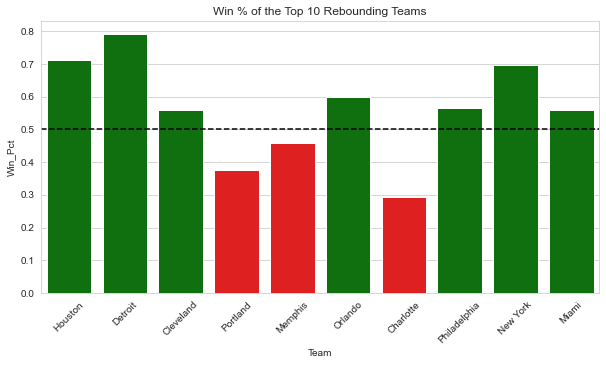

In [16]:
if 'Total_Rebounds' in master_df.columns and 'Win_Pct' in master_df.columns:
    top_10_reb = master_df.nlargest(10, 'Total_Rebounds')
    
    # Win_Pct > 0.5 
    winning_teams = top_10_reb[top_10_reb['Win_Pct'] > 0.5]
    count = len(winning_teams)
    
    print(f"Number of Top 10 Rebounding teams with a Winning Record (> .500): {count}/10")
    print(winning_teams[['Team', 'Total_Rebounds', 'Win_Pct']])
    
    
    plt.figure(figsize=(10, 5))
    colors = ['green' if x > 0.5 else 'red' for x in top_10_reb['Win_Pct']]
    sns.barplot(x='Team', y='Win_Pct', data=top_10_reb, palette=colors)
    plt.axhline(0.5, color='black', linestyle='--')
    plt.title('Win % of the Top 10 Rebounding Teams')
    plt.xticks(rotation=45)
    plt.show()